# EfficientNet Review
- EfficientNet Pytorch
- EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks

In [9]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
# from collections import OrderedDict
from torchsummary import summary
from torch import optim
# from tqdm import tqdm as tqdm

import torchvision
import torchvision.transforms as transforms

## EfficientNet 구축1
EffNet 모델 만들기  
- 논문저자는 tensorflow로 코드를 작성하였기에 다른 사람들이 작성한 pytorch 버전을 참고하여 구현  
- 논문에 나왔던 EfficientNet-B0 모델을 구현

<p align='center'>
    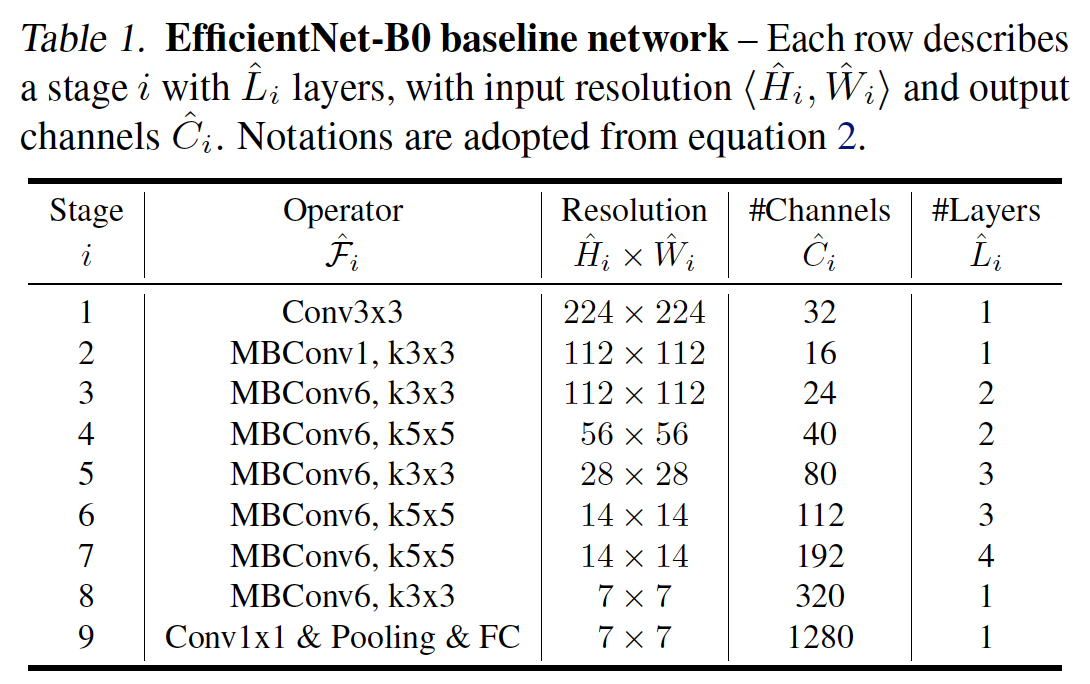
</p>

In [49]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, groups=1):
        super(ConvBlock, self).__init__()
                
        # kernel_size에 따라 padding 변경
        # kernel_size=1 --> padding=0
        # kernel_size=3 --> padding=1
        # kernel_size=5 --> padding=2
        padding = ((kernel_size - 1) // 2)
        
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels,
                                                  out_channels,
                                                  kernel_size,
                                                  stride,
                                                  padding,
                                                  bias=False,
                                                  groups=groups
                                                 ),
                                        nn.BatchNorm2d(out_channels),
                                        nn.SiLU()
                                       )
        
    def forward(self, x):
        return self.conv_block(x)

In [50]:
# Squeeze and Excitation : 채널간 가중치 계산하여 성능 향상

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduce_channels):
        super(SEBlock, self).__init__()
        
        self.se = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                nn.Conv2d(in_channels, reduce_channels, kernel_size=1, stride=1, padding=0, bias=True),
                                nn.SiLU(),
                                nn.Conv2d(reduce_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=True)
                               )
        
    def forward(self, x):
        return x * torch.sigmoid(self.se(x))

<p align='center'>
    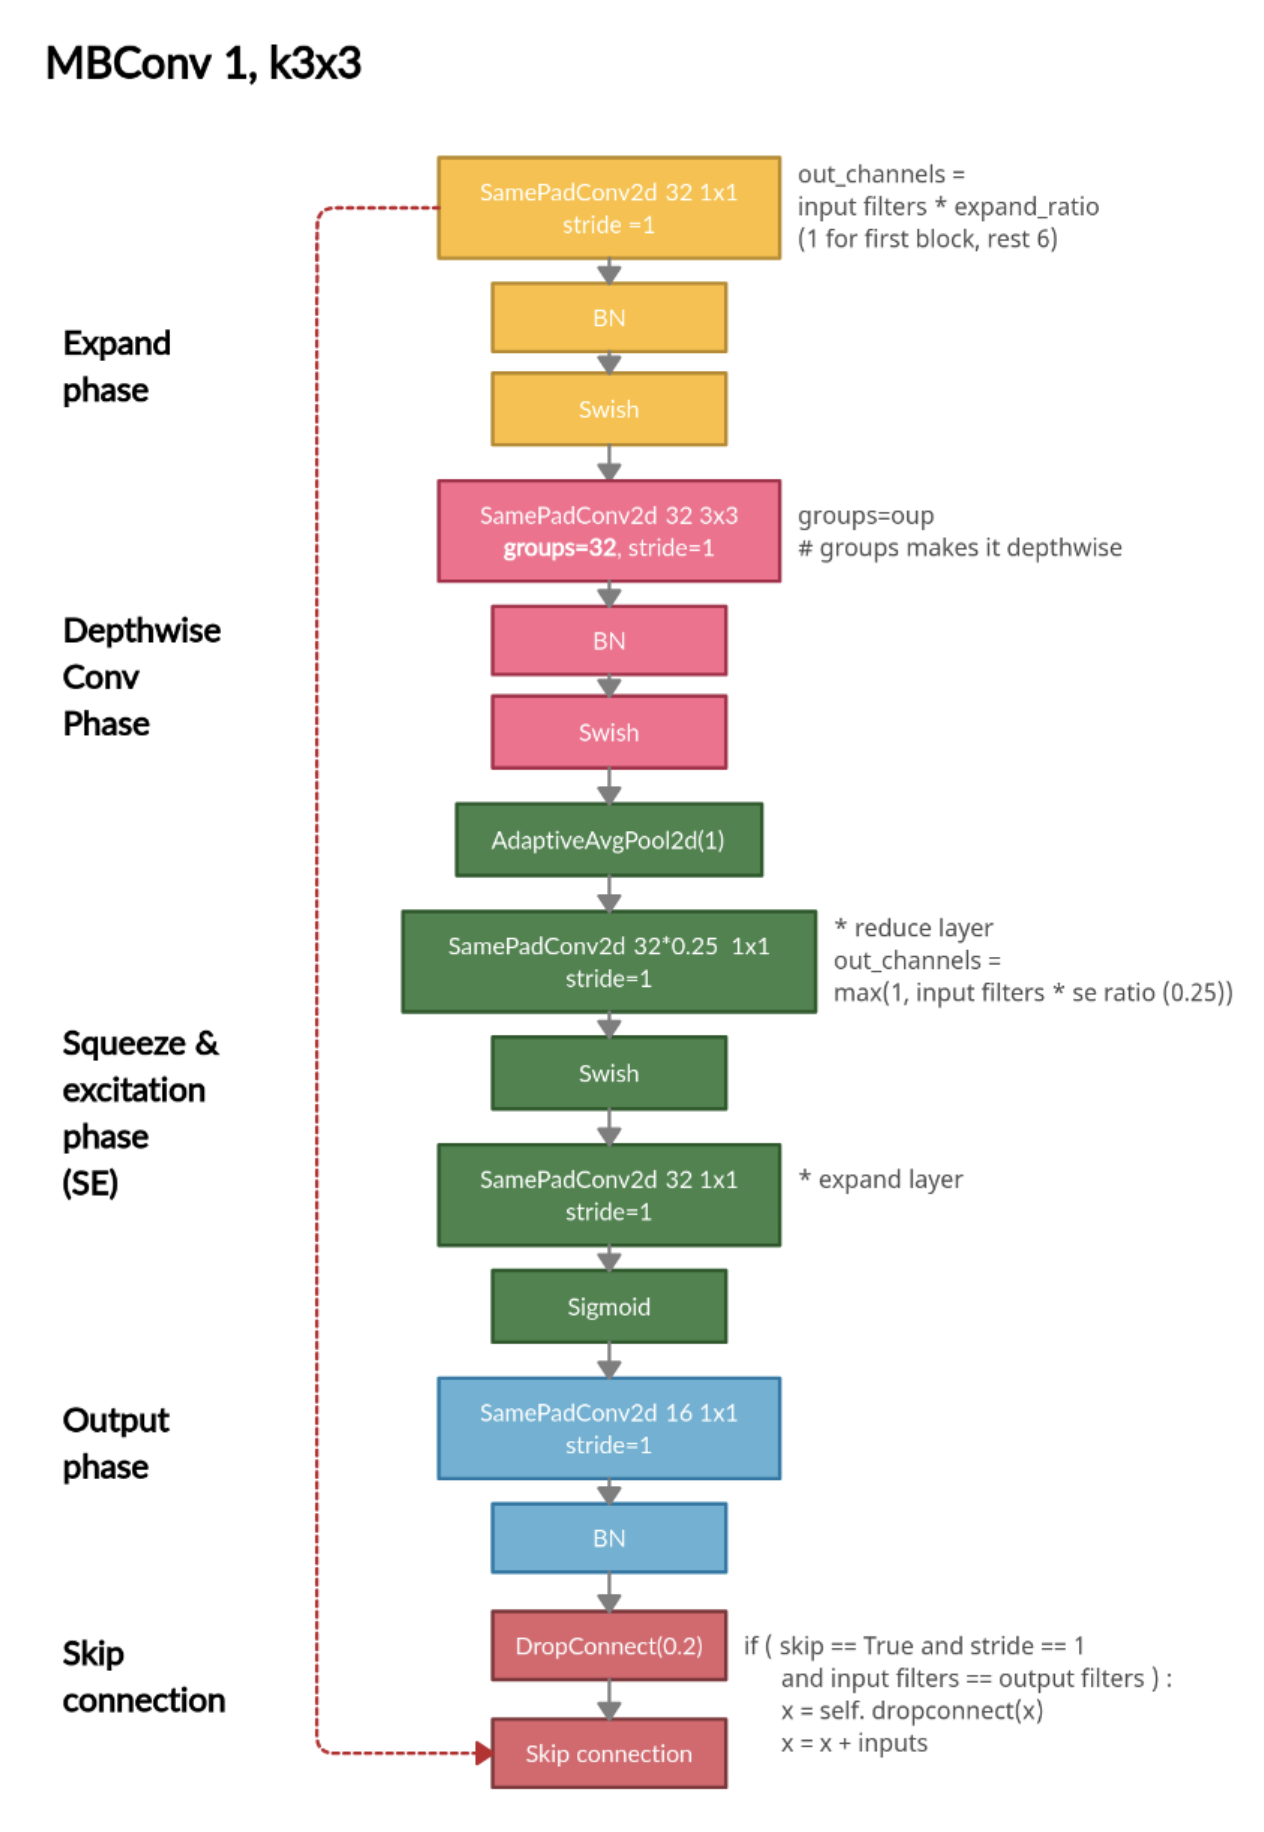
</p>

In [51]:
# linear bottleneck 사용
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand_ratio, kernel_size, stride, reduction_ratio=4, dropout_rate=0.2):
        super(MBConvBlock, self).__init__()
        self.dropout_rate = dropout_rate
        self.expand_ratio = expand_ratio
        
        # reduction_ratio는 얼마나 축소할지 지정하는 변수
        # use_se는 SEBlock을 사용하는 조건 지정
        self.use_se = (reduction_ratio is not None) and (reduction_ratio > 1)
        
        # skip connection 사용을 위한 조건 지정
        self.use_residual = in_channels == out_channels and stride == 1
        
        # expand만큼 채널 확장
        expanded_channels = in_channels * expand_ratio
        
        # SEBlock 사용 시 축소할 채널 변수 지정
        reduced_channels = max(1, int(in_channels/reduction_ratio))
        
        # MBConvBlock 구축 =====================================================================
        # stage1. Expansion phase / Point-wise convolution
        self.expansion = ConvBlock(in_channels=in_channels,
                                       out_channels=expanded_channels,
                                       kernel_size=1)
            
        # stage2. Depth-wise convolution
        self.depth_wise = ConvBlock(in_channels=expanded_channels,
                                    out_channels=expanded_channels,
                                    kernel_size=kernel_size,
                                    stride=stride,
                                    groups=expanded_channels
                                   )
        
        # stage3. Squeeze and Excitation
        self.se_block = SEBlock(in_channels=expanded_channels,
                                reduce_channels=reduced_channels)
            
        # stage4. Point-wise convolution
        self.point_wise = nn.Sequential(nn.Conv2d(in_channels=expanded_channels,
                                                  out_channels=out_channels,
                                                  kernel_size=1,
                                                  stride=1,
                                                  bias=False),
                                        nn.BatchNorm2d(out_channels)
                                       )
        
    def forward(self, x):
                
        # stage1. Expansion phase / Point-wise convolution
        if self.expand_ratio != 1:
            x = self.expansion(x)
            
        # stage2. Depth-wise convolution
        x = self.depth_wise(x)
        
        # stage3. Squeeze and Excitation
        if self.use_se:
            x = self.se_block(x)
            
        # stage4. Point-wise convolution
        x = self.point_wise(x)
        
        # stage5. Skip Connection & Drop Connection
        res = x
        if self.use_residual:
            if self.training and (self.dropout_rate is not None):
                x = F.dropout2d(input=x, p=self.dropout_rate, training=self.training, inplace=True)
                      
            x = x + res
            
        return x

In [52]:
model_select = {
            # "model_name" : (width, depth, resolution, dropout) - already calculated
            "b0" : (1.0, 1.0, 224, 0.2),
            "b1" : (1.0, 1.1, 240, 0.2),
            "b2" : (1.1, 1.2, 260, 0.3),
            "b3" : (1.2, 1.4, 300, 0.3),
            "b4" : (1.4, 1.8, 380, 0.4),
            "b5" : (1.6, 2.2, 456, 0.4),
            "b6" : (1.8, 2.6, 528, 0.5),
            "b7" : (2.0, 3.1, 600, 0.5)
        }

model_base = [
            # expand, kernel_size, stride, channels, layers
            [1, 3, 1, 16, 1],
            [6, 3, 2, 24, 2],
            [6, 5, 2, 40, 2],
            [6, 3, 2, 80, 3],
            [6, 5, 1, 112, 3],
            [6, 5, 2, 192, 4],
            [6, 3, 1, 320, 1]
        ]

In [53]:
class EfficientNet(nn.Module):
    def __init__(self, model_num, num_classes):
        super(EfficientNet, self).__init__()
        
        width, depth, resolution, dropout = model_select[model_num]
        
        # 변수설정
        self.dropout_rate = dropout
        drop_rate = self.dropout_rate # 밑에서 dropout_rate 변경할 때 사용
        
        # stage1
        out_channels = int(32*width)
        self.stage1 = ConvBlock(in_channels=3, out_channels=out_channels, kernel_size=3, stride=2)
               
        # stage 2~8
        in_channels = out_channels
        stage_num = 0
        for expand, kernel_size, stride, channels, layers in model_base:
            
            # SE에서 reduce 4 전처리
            out_channels = 4 * math.ceil(int(channels*width)/4)
            
            layers_repeats = math.ceil(layers*depth)
            
            if self.dropout_rate:
                drop_rate = self.dropout_rate * float(stage_num+1) / len(model_base)
            
            # MBConvBlock 구축
            blocks = []
            for layer in range(layers_repeats):
                blocks.append(MBConvBlock(in_channels=in_channels,
                                          out_channels=out_channels,
                                          expand_ratio=expand,
                                          kernel_size=kernel_size,
                                          stride=stride if layer == 0 else 1,
                                          dropout_rate=dropout
                                         ))
                in_channels = out_channels
            
            self.add_module(f'stage{stage_num+2}', nn.Sequential(blocks[0]))
            stage_num += 1
            
        self.last_channels = math.ceil(1280*width)
        self.stage9 = ConvBlock(in_channels, self.last_channels, 1)
        
        self.classifier = nn.Linear(self.last_channels, num_classes)
        
        
    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.stage8(x)
        x = self.stage9(x)
        
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(-1, self.last_channels)
        out = self.classifier(x)
        
        return out

In [54]:
if __name__ == '__main__':
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    version = 'b0'
    
    x = torch.randn((4, 3, 224, 224)).to(device)
    model = EfficientNet(model_num='b0', num_classes=10).to(device)
    
    print('model result', model(x).shape)
    summary(model, input_size=(3, 224, 224))

model result torch.Size([4, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
         ConvBlock-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]             288
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              SiLU-7         [-1, 32, 112, 112]               0
         ConvBlock-8         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-9             [-1, 32, 1, 1]               0
           Conv2d-10              [-1, 8, 1, 1]             264
             SiLU-11              [-1, 8, 1, 1]               0
           Conv2d-12             [-1, 32, 1, 1]             288
          SEBlock-13         [-1, 32, 112, 112]               0
      

## EfficientNet 구축2
모델을 진행 순서대로 볼 수 있도록 풀어서 구축

In [2]:
# 논문에서 정한 reduction_ratio=0.25

class SEBlock(nn.Module):
    def __init__(self, in_channels, r=0.25):
        super().__init__()
        
        # se_channels : 논문에서 정한 reduce layer out channels 적용방법
        se_channels = max(1, int(in_channels*r))
        
        self.se = nn.Sequential(# squeeze
                                nn.AdaptiveAvgPool2d(1),
                                # excitation
                                nn.Conv2d(in_channels, se_channels, kernel_size=1),
                                nn.SiLU(),
                                nn.Conv2d(se_channels, in_channels, kernel_size=1),
                                nn.Sigmoid()
                               )
        
    def forward(self, x):
        return x * self.se(x)

<p align='center'>
    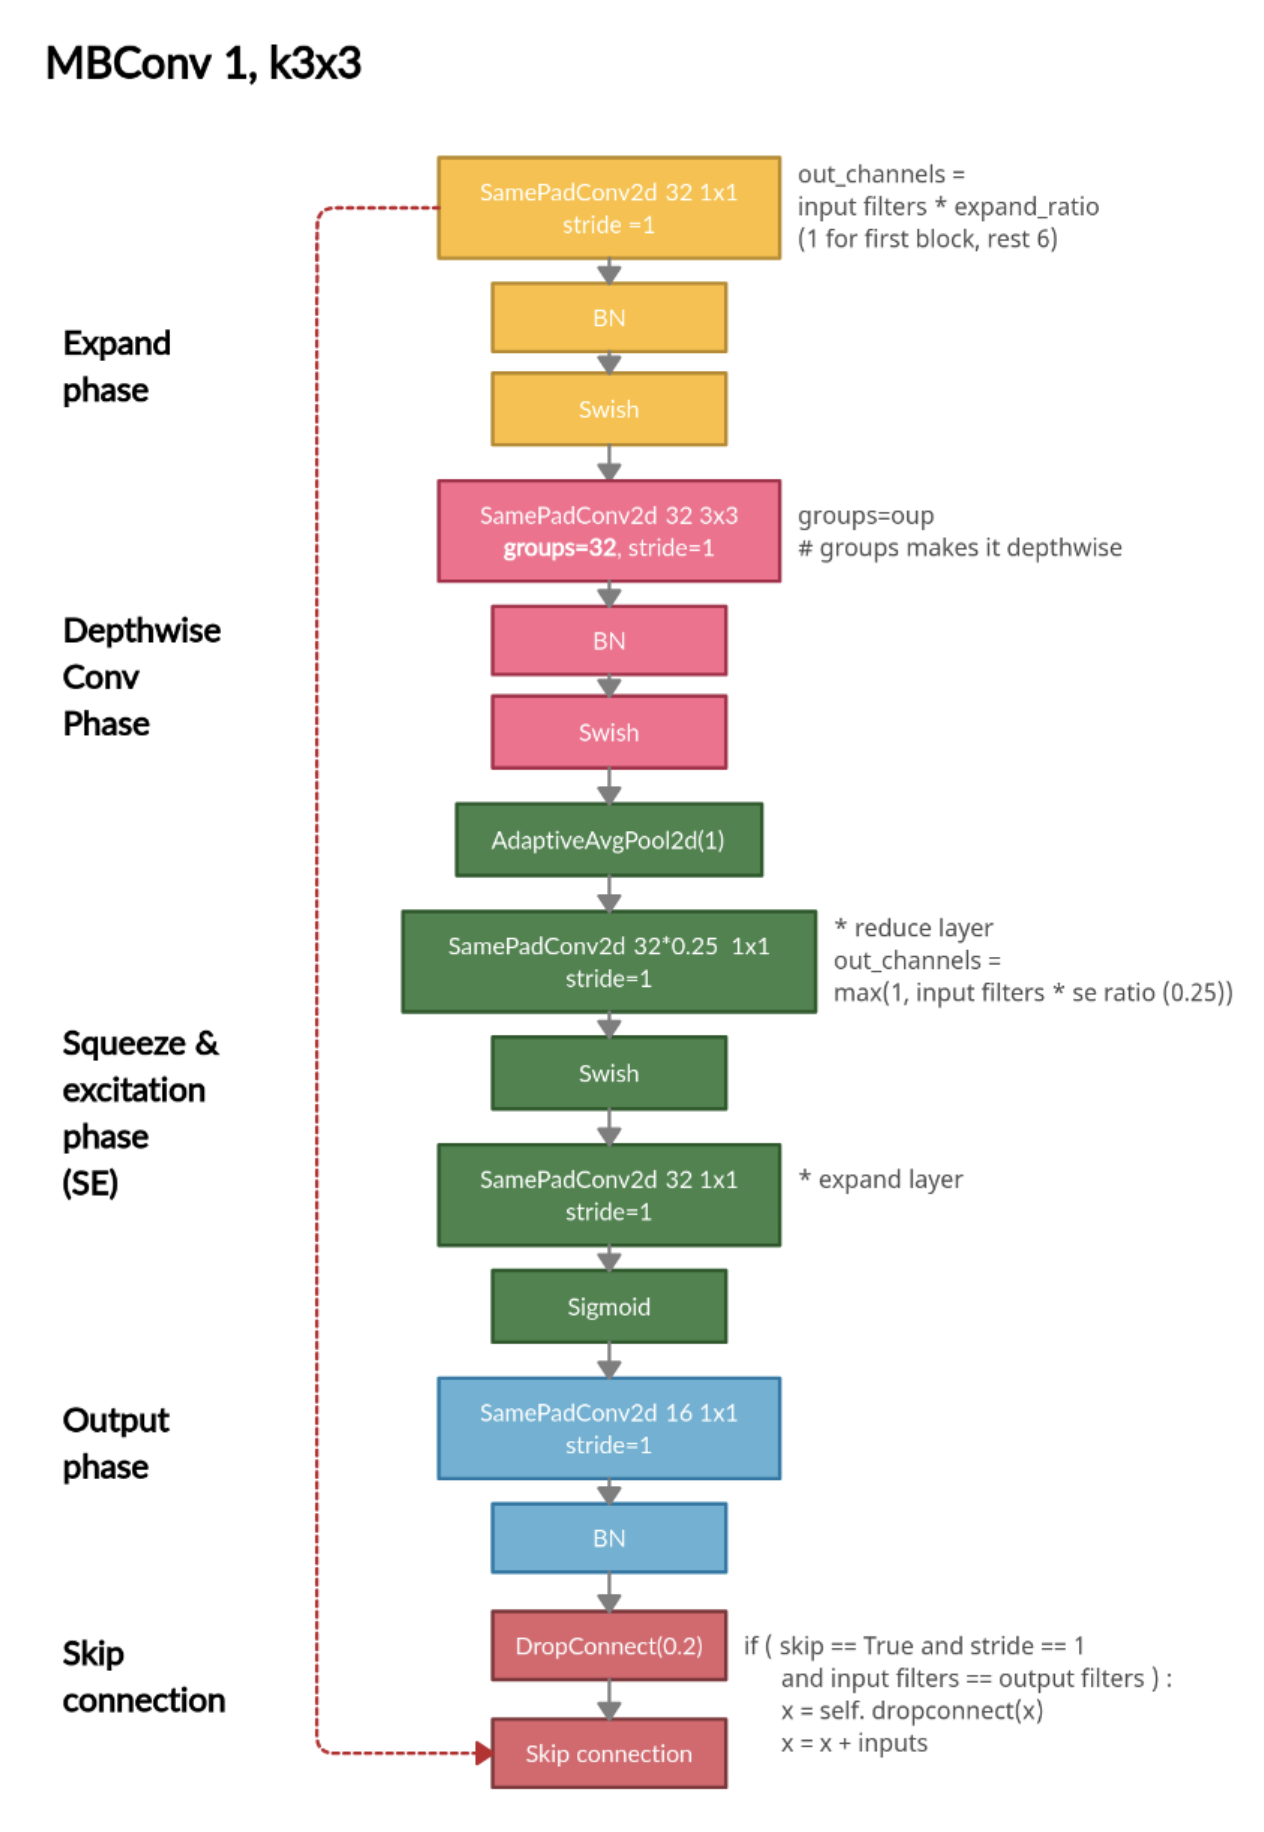
</p>

In [15]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expand, kernel_size, stride=1, r=0.25, dropout_rate=0.2, bias=True):
        super().__init__()
        
        # 변수 설정
        self.dropout_rate = dropout_rate
        self.expand = expand
        
        # skip connection 사용을 위한 조건 지정
        self.use_residual = in_channels == out_channels and stride == 1

        # 논문에서 수행한 BatchNorm, SiLU 적용
        # stage1. Expansion
        expand_channels = in_channels*expand
        self.expansion = nn.Sequential(nn.Conv2d(in_channels, expand_channels, 1, bias=False),
                                       nn.BatchNorm2d(expand_channels, momentum=0.99),
                                       nn.SiLU(),
                                      )

        # stage2. Depth-wise convolution
        padding = ((kernel_size - 1) // 2)
        self.depth_wise = nn.Sequential(nn.Conv2d(expand_channels, expand_channels, kernel_size=kernel_size, stride=1, padding=padding, groups=expand_channels),
                                        nn.BatchNorm2d(expand_channels, momentum=0.99),
                                        nn.SiLU(),
                                       )

        # stage3. Squeeze and Excitation
        self.se_block = SEBlock(expand_channels, r)

        # stage4. Point-wise convolution
        self.point_wise = nn.Sequential(nn.Conv2d(expand_channels, out_channels, 1, 1, bias=False),
                                        nn.BatchNorm2d(out_channels, momentum=0.99)
                                       )

    def forward(self, x):

        # stage1
        if self.expand != 1:
            x = self.expansion(x)
        
        # stage2
        x = self.depth_wise(x)

        # stage3
        x = self.se_block(x)

        # stage4
        x = self.point_wise(x)
        
        # stage5 skip connection
        res = x
        
        if self.use_residual:
            if self.training and (self.dropout_rate is not None):
                x = F.dropout2d(input=x, p=self.dropout_rate, training=self.training, inplace=True)
            
            x = x + res
            
        return x

In [19]:
class EfficientNet2(nn.Module):
    def __init__(self, num_classes, width, depth, resolution, dropout):
        super().__init__()
        
        # stage1
        out_ch = int(32*width)
        self.stage1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=out_ch, kernel_size=3, stride=2, padding=1),
                                    nn.BatchNorm2d(out_ch, momentum=0.99))
        
        # stage2
        self.stage2 = nn.Sequential(MBConvBlock(in_channels=out_ch, out_channels=16, expand=1, kernel_size=3, stride=1, dropout_rate=dropout))
        
        # stage3
        self.stage3 = nn.Sequential(MBConvBlock(in_channels=16, out_channels=24, expand=6, kernel_size=3, stride=2, dropout_rate=dropout),
                                    MBConvBlock(in_channels=24, out_channels=24, expand=6, kernel_size=3, stride=2, dropout_rate=dropout),
                                   )
        
        # stage4
        self.stage4 = nn.Sequential(MBConvBlock(in_channels=24, out_channels=40, expand=6, kernel_size=5, stride=2, dropout_rate=dropout),
                                    MBConvBlock(in_channels=40, out_channels=40, expand=6, kernel_size=5, stride=2, dropout_rate=dropout),
                                   )
        
        # stage5
        self.stage5 = nn.Sequential(MBConvBlock(in_channels=40, out_channels=80, expand=6, kernel_size=3, stride=2, dropout_rate=dropout),
                                    MBConvBlock(in_channels=80, out_channels=80, expand=6, kernel_size=3, stride=2, dropout_rate=dropout),
                                    MBConvBlock(in_channels=80, out_channels=80, expand=6, kernel_size=3, stride=2, dropout_rate=dropout),
                                   )
        
        # stage6
        self.stage6 = nn.Sequential(MBConvBlock(in_channels=80, out_channels=112, expand=6, kernel_size=5, stride=1, dropout_rate=dropout),
                                    MBConvBlock(in_channels=112, out_channels=112, expand=6, kernel_size=5, stride=1, dropout_rate=dropout),
                                    MBConvBlock(in_channels=112, out_channels=112, expand=6, kernel_size=5, stride=1, dropout_rate=dropout),
                                   )
        
        # stage7
        self.stage7 = nn.Sequential(MBConvBlock(in_channels=112, out_channels=192, expand=6, kernel_size=5, stride=2, dropout_rate=dropout),
                                    MBConvBlock(in_channels=192, out_channels=192, expand=6, kernel_size=5, stride=2, dropout_rate=dropout),
                                    MBConvBlock(in_channels=192, out_channels=192, expand=6, kernel_size=5, stride=2, dropout_rate=dropout),
                                    MBConvBlock(in_channels=192, out_channels=192, expand=6, kernel_size=5, stride=2, dropout_rate=dropout),
                                   )
        
        # stage8
        self.stage8 = nn.Sequential(MBConvBlock(in_channels=192, out_channels=320, expand=6, kernel_size=3, stride=1, dropout_rate=dropout))
        
        # stage9
        self.last_channels = math.ceil(1280*width)
        self.stage9 = nn.Conv2d(in_channels=320, out_channels=self.last_channels, kernel_size=1)
        
        # result
        self.out_layer = nn.Linear(self.last_channels, num_classes)
        
    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.stage8(x)
        x = self.stage9(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(-1, self.last_channels)
        x = self.out_layer(x)
        
        return x

In [20]:
def efficientnet_b0(num_classes=10):
    return EfficientNet2(num_classes=num_classes, width=1.0, depth=1.0, resolution=224, dropout=0.2)

def efficientnet_b1(num_classes=10):
    return EfficientNet2(num_classes=num_classes, width=1.0, depth=1.1, resolution=240, dropout=0.2)

def efficientnet_b2(num_classes=10):
    return EfficientNet2(num_classes=num_classes, width=1.1, depth=1.2, resolution=260, dropout=0.3)

def efficientnet_b3(num_classes=10):
    return EfficientNet2(num_classes=num_classes, width=1.2, depth=1.4, resolution=300, dropout=0.3)

def efficientnet_b4(num_classes=10):
    return EfficientNet2(num_classes=num_classes, width=1.4, depth=1.8, resolution=380, dropout=0.4)

def efficientnet_b5(num_classes=10):
    return EfficientNet2(num_classes=num_classes, width=1.6, depth=2.2, resolution=456, dropout=0.4)

def efficientnet_b6(num_classes=10):
    return EfficientNet2(num_classes=num_classes, width=1.8, depth=2.6, resolution=528, dropout=0.5)

def efficientnet_b7(num_classes=10):
    return EfficientNet2(num_classes=num_classes, width=2.0, depth=3.1, resolution=600, dropout=0.5)

In [21]:
if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    x = torch.randn(4, 3, 224, 224).to(device)
    model = efficientnet_b0().to(device)
    output = model(x)
    print('output size:', output.size())
    
    summary(model, input_size=(3, 224, 224))

output size: torch.Size([4, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
            Conv2d-3         [-1, 32, 112, 112]             320
       BatchNorm2d-4         [-1, 32, 112, 112]              64
              SiLU-5         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-6             [-1, 32, 1, 1]               0
            Conv2d-7              [-1, 8, 1, 1]             264
              SiLU-8              [-1, 8, 1, 1]               0
            Conv2d-9             [-1, 32, 1, 1]             288
          Sigmoid-10             [-1, 32, 1, 1]               0
          SEBlock-11         [-1, 32, 112, 112]               0
           Conv2d-12         [-1, 16, 112, 112]             512
      BatchNorm2d-13         [-1, 16, 112, 112]              32
      

## EfficientNet 패키지
- efficientnet_pytorch 패키지 (pip install efficientnet_pytorch)
- torch 내 nvidia 패키지 (torch.hub.load())

In [14]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')
model

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

## EfficientNet_실습

In [36]:
import os
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import time
import copy

from torch.optim import lr_scheduler
from torchvision import datasets
from efficientnet_pytorch import EfficientNet

In [37]:
# cuda 사용
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [77]:
# 변수설정
batch_size = 128
n_epochs = 10
lr = 0.1
data_dir = '/data/paper_review/cifa10'

In [64]:
# 데이터 불러오기
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                               ])

trainset = torchvision.datasets.CIFAR10(root=data_dir+'/train', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

valset = torchvision.datasets.CIFAR10(root=data_dir+'/test', train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [78]:
# model 정의
model = EfficientNet(model_num='b0', num_classes=10).to(device)

# 비용함수, 옵티마이저 정의
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [85]:
# 학습
for epoch in range(n_epochs):
    avg_cost = 0
    accuracy = 0
    
    for X, Y in trainloader:
        X = X.to(device)
        Y = Y.to(device)
        
        # 가설
        hypothesis = model(X)
        
        # loss
        loss = cost(hypothesis, Y)
        
        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # avg_cost
        avg_cost += loss / len(trainloader)
        correct = torch.argmax(hypothesis, 1) == Y
        accuracy = correct.float().mean()
        
    print(f'Epoch {epoch}/{n_epochs}\tLoss {avg_cost:.4f}\tAcc {accuracy:.4f}')

Epoch 0/10	Loss 1.1206	Acc 0.6375
Epoch 1/10	Loss 0.9989	Acc 0.5875
Epoch 2/10	Loss 0.9212	Acc 0.6125
Epoch 3/10	Loss 0.8967	Acc 0.6500
Epoch 4/10	Loss 0.7848	Acc 0.7625
Epoch 5/10	Loss 0.7703	Acc 0.8000
Epoch 6/10	Loss 0.6756	Acc 0.7875
Epoch 7/10	Loss 0.6785	Acc 0.8000
Epoch 8/10	Loss 0.6556	Acc 0.6250
Epoch 9/10	Loss 0.6320	Acc 0.7750


In [94]:
avg_accuracy = []

for X, Y in valloader:
    X = X.to(device)
    Y = Y.to(device)
    
    pred = model(X)
    correct = torch.argmax(pred, 1) == Y
    accuracy = correct.float().mean()
    avg_accuracy.append(accuracy)

print('Accuracy:', sum(avg_accuracy)/len(avg_accuracy))

Accuracy: tensor(0.7851, device='cuda:0')
